# RSI - Relative Strength Index

Jaime Lopez \<jailop AT protonmail DOT com\>  
Jul. 12, 2024

This notebook shows an implementation for the RSI financial indicator.

RSI measures speed and magnitude of price changes to evaluate overvalued or undervalued conditions.

As empirical rule, when RSI is greater than 70 signs that prices are overvalued, while when RSI is less than 30 signs that prices are undervalued. Therefore a reversion is expected after those points.

As case of study, TSLA stock prices on the second half of 2023 are used as example.

## Setting environment and retrieving data

In [1]:
# Setting the environment
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance

In [2]:
# Parameters
symbol = "TSLA"
start = "2023-07-01"
end = "2023-12-31"
period = "1d"

In [3]:
# Retrieving data
ticker = yfinance.Ticker(symbol)
data = ticker.history(start=start, end=end, period=period)
data.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-12-22 00:00:00-05:00,256.760010,258.220001,251.369995,252.539993,93249800,0.0,0.0
2023-12-26 00:00:00-05:00,254.490005,257.970001,252.910004,256.609985,86892400,0.0,0.0
2023-12-27 00:00:00-05:00,258.350006,263.339996,257.519989,261.440002,106494400,0.0,0.0
2023-12-28 00:00:00-05:00,263.660004,265.130005,252.710007,253.179993,113619900,0.0,0.0
2023-12-29 00:00:00-05:00,255.100006,255.190002,247.429993,248.479996,100615300,0.0,0.0


## Step by step

As the first step, we need to calculate relative gains and losses for each day. A gain is obtained when the close price is greater than the open price. A loss is when the close price is less than the open price.

$$
\text{Gain} = \begin{cases}
    \frac{P_\text{close} - P_\text{open}}{P_\text{open}}, P_\text{close} \geq P_\text{open} \\
    0, P_\text{close} < P_\text{open}
\end{cases}
$$

$$
\text{Loss} = \begin{cases}
    \frac{P_\text{close} - P_\text{open}}{P_\text{open}}, P_\text{close} < P_\text{open} \\
    0, P_\text{close} \geq P_\text{open}
\end{cases}
$$

In [4]:
# Difference relative between close and open prices
data["Diff"] = (data["Close"] - data["Open"]) / data["Open"]
# Gain if relative difference is positive
data["Gain"] = data["Diff"].apply(lambda diff: diff if diff >= 0.0 else 0.0)
# Loss if relative difference is negative
data["Loss"] = data["Diff"].apply(lambda diff: -diff if diff < 0.0 else 0.0)
data.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Diff,Gain,Loss
Date,,,,,,,,,,
2023-12-22 00:00:00-05:00,256.760010,258.220001,251.369995,252.539993,93249800,0.0,0.0,-0.016436,0.000000,0.016436
2023-12-26 00:00:00-05:00,254.490005,257.970001,252.910004,256.609985,86892400,0.0,0.0,0.008330,0.008330,0.000000
2023-12-27 00:00:00-05:00,258.350006,263.339996,257.519989,261.440002,106494400,0.0,0.0,0.011961,0.011961,0.000000
2023-12-28 00:00:00-05:00,263.660004,265.130005,252.710007,253.179993,113619900,0.0,0.0,-0.039748,0.000000,0.039748
2023-12-29 00:00:00-05:00,255.100006,255.190002,247.429993,248.479996,100615300,0.0,0.0,-0.025951,0.000000,0.025951


RSI is computed in two steps. In the first one, the following formula is used. $Avg. Gain$ is the average gain for a period of time. $Avg. Loss$ is the average loss for a period of time. The period of time usually used is 14 days.

$$\text{RSI}_{\text{step one}} = 100 - \frac{100}{1 + \frac{\text{Avg. Gain}}{\text{Avg. Loss}}}$$

In [5]:
start = 0
end = 15
avg_gain = data[start:end]["Gain"].sum() / (end - start - 1)
avg_loss = data[start:end]["Loss"].sum() / (end - start - 1)
rsi_step_one = 100 - 100 / (1 + avg_gain / avg_loss)
print("RSI1: {:0.2f}".format(rsi_step_one))

RSI1: 44.48


In the second step, average gain and loss values are combined with the current gain or loss.

$$\text{RSI}_{\text{step two}} = 100 - \frac{100}{1 + \frac{\text{Avg. Gain} \times 13 + \text{Curr. Gain}}{\text{Avg. Loss} \times 13 + \text{Curr. Loss}}}$$

In [6]:
curr_gain = data.iloc[end]["Gain"]
curr_loss = data.iloc[end]["Loss"]
factor = end - start - 2
rsi_step_two = 100 - 100 / (1 + (avg_gain * factor + curr_gain) / (avg_loss * factor + curr_loss))
print("RSI2: {:0.2f}".format(rsi_step_two))

RSI2: 40.66


## RSI over the entire period

In this section, RSI values are computed for the entire period under study.

In [7]:
period = 14
data["AvgGain"] = data["Gain"].rolling(window=period).mean()
data["AvgLoss"] = data["Loss"].rolling(window=period).mean()
data["RSI1"] = 100 - 100 / (1 + data["AvgGain"] / data["AvgLoss"])

In [8]:
data["gainFactor"] = data["AvgGain"].shift(1) * (period - 1) + data["Gain"]
data["lossFactor"] = data["AvgLoss"].shift(1) * (period - 1) + data["Loss"]
data["RSI2"] = 100 - 100 / (1 + data["gainFactor"] / data["lossFactor"])

Removing rows with null values

In [9]:
data = data.dropna()

## Plotting results

In [10]:
def plot_charts(df: pd.DataFrame, column: str):
    fig, ax = plt.subplots(nrows=2, figsize=(16,8))
    ax[0].fill_between(data.index, data["Open"], data["Close"], where=(data["Close"] > data["Open"]), color="g", label="Gain")
    ax[0].fill_between(data.index, data["Open"], data["Close"], where=(data["Open"] > data["Close"]), color="r", label="Loss")
    ax[0].set_title("Open/Close Prices")
    ax[0].legend()
    ax[0].set_ylabel("Price (USD)")
    data[column].plot(ax=ax[1])
    ax[1].axhline(70, color="g")
    ax[1].axhline(30, color="r")
    ax[1].set_title("RSI1")
    ax[1].set_ylim([0, 100])

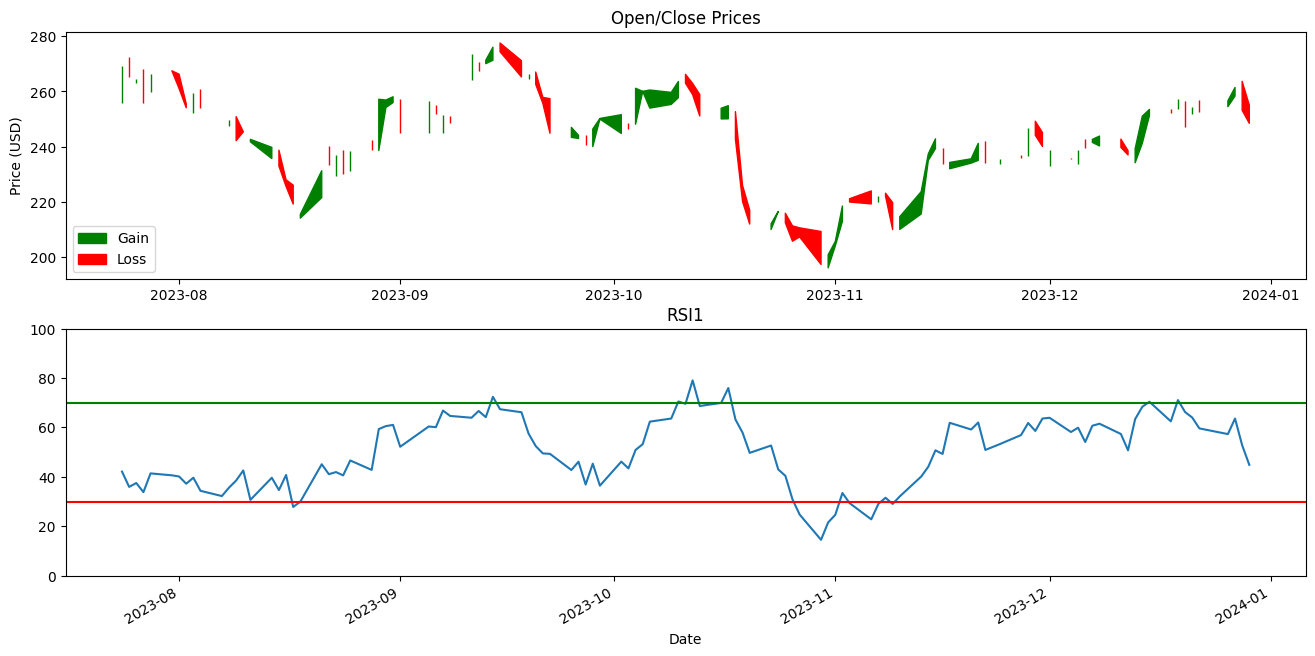

In [11]:
plot_charts(data, "RSI1")

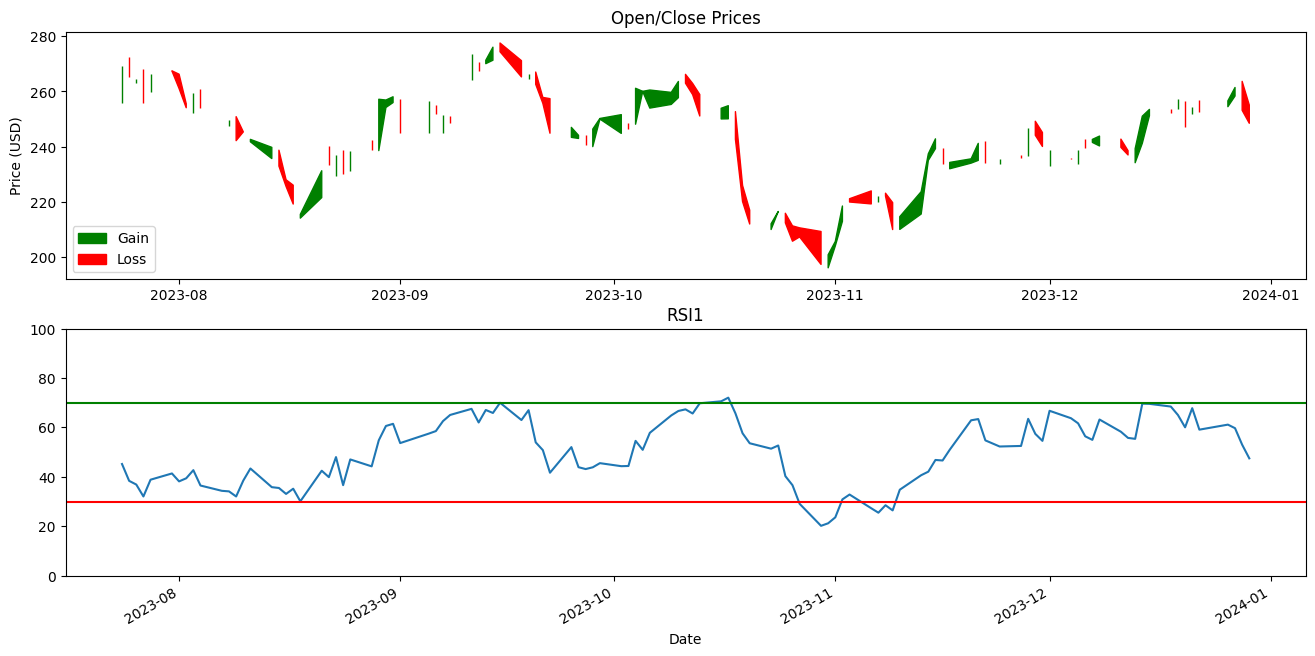

In [12]:
plot_charts(data, "RSI2")

**References:**

* Fernando, J. (Apr. 10, 2024). [Relative Strength Index (RSI) Indicator Explained With Formula](https://www.investopedia.com/terms/r/rsi.asp). Investopedia.
* StockCharts (nd). [Relative Strength Index (RSI)](https://chartschool.stockcharts.com/table-of-contents/technical-indicators-and-overlays/technical-indicators/relative-strength-index-rsi).